In [34]:
import numpy as np 
import sympy as sp
from copy import copy 
import itertools

In [ ]:
def ϵijk(i,j,k):

    if i==k or j==k:
        return 0 
    elif (i,j,k) == ((1,2,3) or (2,3,1) or (3,1,2)):
        return 1 
    if (i,j,k) == ((3,2,1) or (1,3,2) or (2,1,3)):
        return -1 

levi_civita = ϵijk

def initialize_generators(D, symbols_list):

    """
    Initializes a set of generator matrices using symbolic variables.

    Parameters:
    -----------
    D : int
        The dimension of the generator matrices (each matrix will be of size DxD).
    
    symbols_list : list
        A list of symbolic variables that will be used to populate the matrices.
        It should have at least `2 * D^2` elements to construct the required matrices.

    Returns:
    --------
    generators : list of sympy.Matrix
        A list containing two DxD symbolic matrices.

    Notes:
    ------
    - The function sequentially populates each matrix with symbols from `symbols_list`.
    - The input `symbols_list` should have sufficient elements; otherwise, `pop()` will raise an `IndexError`.
    - Each generator is stored as a `sympy.Matrix` with complex entries.
    """

    generators = []
    symbols_copy = copy(symbols_list)  # Generates x0, x1, ..., x_{d^3-1})
    for _ in range(1,3):
        rows = [ ]
        for _ in range(D):
            cols = []
            for _ in range(D):
                cols.append(symbols_copy.pop(0))
            rows.append(cols)
        generators.append(sp.Matrix(rows,type=complex))

    return generators

def initialize_eigenstates(eigenstates):
    """
    Converts a given set of eigenstates into symbolic SymPy matrices.

    Parameters:
    -----------
    eigenstates : np.ndarray
        A NumPy array where each **column** represents an eigenstate.
        The shape should be (D, N), where:
        - `D` is the dimension of each eigenstate vector.
        - `N` is the number of eigenstates.

    Returns:
    --------
    symbolic_eigenstates : list of sympy.Matrix
        A list containing symbolic representations of the eigenstates as `sympy.Matrix` objects.
        Each matrix is treated as a complex-valued column vector.

    Notes:
    ------
    - Each eigenstate (a column in `eigenstates`) is converted into a `sympy.Matrix` of size `(D, 1)`.
    - Assumes that `eigenstates` is well-formed and contains numeric values before conversion.
    - The function does **not** modify the original `eigenstates` array.
    """

    symbolic_eigenstates = []
    for j in range(eigenstates.shape[1]):
        symbolic_eigenstate = sp.Matrix(eigenstates[:,j],type=complex)
        symbolic_eigenstates.append(symbolic_eigenstate)
    return symbolic_eigenstates

def form_matrix_irrep_so3(j:int) -> list[sp.Matrix] :

    """

    """
    j = 1/2 
    D = int(2*j+1)
    js = np.arange(j, -j-1, -1,dtype=complex)
    J3 = sp.Matrix(np.diag(js))

    # form eigenvectors of J3 
    eigenstates = np.eye(D, dtype=complex)

    # form variables in the generators 
    num_vars = D**2*2  # Number of variables
    # Generate symbols as a flattened list
    symbols_list = [*sp.symbols(f'x:{num_vars}')]  # Generates x0, x1, ..., x_{d^3-1}
    generators = initialize_generators(D,symbols_list)
    symbolic_eigenstates = initialize_eigenstates(eigenstates)

    # iterate over all matrice to be constructed
    for i in range(D):
        if i == 0: 
            prefactor = 2.0
            # iterate over all columns, or rather pairs of columns 

            col_sol1 = sp.solve(prefactor*generators[i]*symbolic_eigenstates[0]-symbolic_eigenstates[1] ,symbols_list[:4],dict=True)
            col_sol2 = sp.solve(prefactor*generators[i]*symbolic_eigenstates[1]-symbolic_eigenstates[0] ,symbols_list[:4],dict=True)
            print(list(col_sol1[0].values()))
            mat = [ list(col_sol1[0].values()),list(col_sol2[0].values())]
            generators[i] = sp.Matrix(mat).T
        else : 
            prefactor = 2.0j 
            # iterate over all columns, or rather pairs of columns 
            col_sol1 = sp.solve(prefactor*generators[i]*symbolic_eigenstates[0]+symbolic_eigenstates[1] ,symbols_list[4:],dict=True)
            col_sol2 = sp.solve(prefactor*generators[i]*symbolic_eigenstates[1]-symbolic_eigenstates[0] ,symbols_list[4:],dict=True)
            mat = [ list(col_sol1[0].values()),list(col_sol2[0].values())]
            generators[i] = sp.Matrix(mat).T

    return [*generators,J3]

In [3]:
def reassemble_mat_from_sols(D, sols):
    """
    Reconstructs a DxD SymPy matrix from a list of solution dictionaries.

    Parameters:
    -----------
    D : int
        The dimension of the square matrix (D x D).
    
    sols : list of dict
        A list where each dictionary represents a partial solution with 
        symbolic keys (e.g., x0, x1, ...) and their corresponding values.

    Returns:
    --------
    sp.Matrix
        A SymPy matrix of size (D x D) with values sorted according to 
        their symbolic variable indices.

    Notes:
    ------
    - The function merges all dictionaries in `sols` into one.
    - It extracts and sorts values based on the numerical index of their symbolic keys.
    - The values are then used to construct a D x D matrix.
    - Assumes the number of extracted values matches `D*D`; otherwise, an error occurs.

    Example:
    --------
    >>> sols = [
    ...     {sp.Symbol('x0'): 0.5, sp.Symbol('x1'): 0.0},
    ...     {sp.Symbol('x2'): 1.0, sp.Symbol('x3'): -0.5}
    ... ]
    >>> reassemble_mat_from_sols(2, sols)
    Matrix([
    [0.5, 0.0],
    [1.0, -0.5]
    ])
    """
    
    merged_dict = {key: value for d in sols for key, value in d.items()}
    sorted_dict = sorted(merged_dict.items(), key=lambda item: int(str(item[0])[1:]))
    sorted_vals = [val for (_, val) in sorted_dict]
    return sp.Matrix(D, D, sorted_vals)

def form_matrix_irrep_so3(j:int) -> list[sp.Matrix] :

    """
    Constructs the SO(3) irreducible representation (irrep) matrices for a given spin value j.

    Parameters:
    -----------
    j : int
        The total angular momentum quantum number (j). It determines the dimension 
        of the representation as D = 2j + 1.

    Returns:
    --------
    list[sp.Matrix]
        A list containing the SO(3) generators in matrix form: [J1, J2, J3].
        - J1 (J_x): The first generator of the SO(3) algebra.
        - J2 (J_y): The second generator of the SO(3) algebra.
        - J3 (J_z): The third generator of the SO(3) algebra (diagonal form).

    Notes:
    ------
    - The function first constructs the eigenstates of J3.
    - It initializes the generator matrices using symbolic variables.
    - It solves for the matrix elements by imposing the SO(3) commutation relations.
    - The solution is reassembled into matrices using `reassemble_mat_from_sols`.
    - The final output consists of the three angular momentum operators J1, J2, and J3.

    Example:
    --------
    >>> import sympy as sp
    >>> J_matrices = form_matrix_irrep_so3(1)
    >>> for J in J_matrices:
    ...     sp.pprint(J)

    This will return the 3×3 matrices representing the SO(3) Lie algebra generators 
    for j = 1 in the standard representation.
    """
    
    D = int(2*j+1)
    js = np.arange(j,-j-1, -1,dtype=complex)
    J3 = sp.Matrix(np.diag(js))

    # form eigenvectors of J3 
    eigenstates = np.eye(D, dtype=complex)

    # form variables in the generators 
    num_vars = D**2*2  # Number of variables
    # Generate symbols as a flattened list
    symbols_list = [*sp.symbols(f'x:{num_vars}')]  # Generates x0, x1, ..., x_{d^3-1}
    generators = initialize_generators(D,symbols_list)
    symbolic_eigenstates = initialize_eigenstates(eigenstates)
    null_ket = sp.Matrix(np.zeros(D,dtype=complex))

    for (i,prefactor) in enumerate([2.0, 2.0j]):
        
        # iterate over all columns, or rather pairs of columns 
        sols = []
        for k, m in enumerate(js):
            # eig = symbolic_eigenstates[k]
            m_plus1_state, m_minus1_state = null_ket, null_ket
                # Check bounds before accessing elements
                    # Ensure `i - 1` is valid before accessing it
            if k >= 0 and m + 1 <= j:  
                prefactor_up = (j * (j + 1) - m * (m + 1))**(1/2)
                m_plus1_state = prefactor_up * symbolic_eigenstates[k - 1]

            # Ensure `i + 1` is valid before accessing it
            if k <= len(js) - 1  and m - 1 >= -j:  
                prefactor_down = (j * (j + 1) - m * (m - 1))**(1/2)
                m_minus1_state = prefactor_down * symbolic_eigenstates[k + 1]

            rhs = -m_plus1_state - m_minus1_state if prefactor == 2.0 else -m_plus1_state + m_minus1_state
            symbols = symbols_list[:num_vars//2] if prefactor == 2.0 else symbols_list[num_vars//2:] 
            sol = sp.solve(prefactor*generators[i]*symbolic_eigenstates[k]+rhs ,symbols,dict=True)[0]
            sols.append(sol)
        J = reassemble_mat_from_sols(D,sols)
        generators[i] = J 
    
    return generators + [J3]

In [4]:
form_matrix_irrep_so3(j=1/2)

[Matrix([
 [0.0, 0.5],
 [0.5, 0.0]]),
 Matrix([
 [  0.0, -0.5*I],
 [0.5*I,    0.0]]),
 Matrix([
 [0.5,    0],
 [  0, -0.5]])]

In [5]:
J1, J2, J3 = form_matrix_irrep_so3(j=1/2)

In [6]:
J1

Matrix([
[0.0, 0.5],
[0.5, 0.0]])

In [7]:
J2

Matrix([
[  0.0, -0.5*I],
[0.5*I,    0.0]])

In [8]:
J3

Matrix([
[0.5,    0],
[  0, -0.5]])

In [9]:
J1, J2, J3 = form_matrix_irrep_so3(j=1)

In [10]:
J1

Matrix([
[              0.0, 0.707106781186545,               0.0],
[0.707106781186545,               0.0, 0.707106781186545],
[              0.0, 0.707106781186545,               0.0]])

In [11]:
J2

Matrix([
[                0.0, -0.707106781186545*I,                  0.0],
[0.707106781186545*I,                  0.0, -0.707106781186545*I],
[                0.0,  0.707106781186545*I,                  0.0]])

In [12]:
J3

Matrix([
[1.0, 0,    0],
[  0, 0,    0],
[  0, 0, -1.0]])

In [13]:
J1, J2, J3 = form_matrix_irrep_so3(j=3/2)

In [14]:
J1

Matrix([
[             0.0, 0.86602540378444,              0.0,              0.0],
[0.86602540378444,              0.0,              1.0,              0.0],
[             0.0,              1.0,              0.0, 0.86602540378444],
[             0.0,              0.0, 0.86602540378444,              0.0]])

In [15]:
J2

Matrix([
[               0.0, -0.86602540378444*I,                0.0,                 0.0],
[0.86602540378444*I,                 0.0,             -1.0*I,                 0.0],
[               0.0,               1.0*I,                0.0, -0.86602540378444*I],
[               0.0,                 0.0, 0.86602540378444*I,                 0.0]])

In [16]:
J3

Matrix([
[1.5,   0,    0,    0],
[  0, 0.5,    0,    0],
[  0,   0, -0.5,    0],
[  0,   0,    0, -1.5]])

In [237]:
def ϵijk(i,j,k):
    assert (i and j and k) >0 and (i and j and k) < 4  
    if i == j or j == k or i == k:  # Fix condition: i == j should be checked too
        return 0 
    if (i, j, k) in [(1,2,3), (2,3,1), (3,1,2)]:
        return 1 
    if (i, j, k) in [(3,2,1), (1,3,2), (2,1,3)]:
        return -1 
    

def δij(i,j): 

    if i ==j :
        return 1 
    elif i != j:
        return 0 


def trace(A: sp.Matrix) -> sp.Matrix: 
    """
    """
    N = A.shape[0]
    t = sum(A.diagonal())
    t_type = type(A[0])
    I = sp.eye(N, dtype=t_type)
    return t * I

levi_civita = ϵijk

def commutator(A: sp.Matrix,B:sp.Matrix)->sp.Matrix:
    return A*B - B*A

def anti_commutator(A: sp.Matrix, B: sp.Matrix) -> sp.Matrix:
    return A*B+B*A

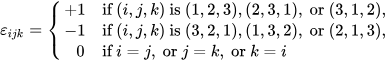

In [244]:

j = 1/2
Js = form_matrix_irrep_so3(j=j)
σ = [2.0 * J for J in Js]

triple_index_permutations = list(itertools.permutations([0,1,2]))

double_index_permutations = (list(itertools.permutations([0,1])) + 
                         list(itertools.permutations([1,2])) +
                         list(itertools.permutations([0,2])))

def test_commutation_relation(Js: list[sp.Matrix],
                              permuted_indices: list[tuple]):
    """
    """
    for p in permuted_indices:
        i,j,k = p
        assert commutator(Js[i],Js[j]) == 2j*ϵijk(i+1,j+1,k+1)*Js[k]


def test_anticommutation_relation(Js: list[sp.Matrix],
                                  permuted_indices: list[tuple]):
    """
    """
    N = Js[0].shape[0]
    for p in permuted_indices:
        i,j = p
        assert anti_commutator(Js[i],Js[j]) == 2.0*δij(i,j)*sp.eye(N)

-1.
def test_trace_relation(Js: list[sp.Matrix],
                        permuted_indices: list[tuple]): 
    """ 
    """
    N = Js[0].shape[0]
    for p in permuted_indices:
        i,j = p 
        print(i,j)
        assert trace(Js[i] @ Js[j]) == 2.0 * δij(i,j) * sp.eye(N)


def test_σ2_relation(Js,σ):
    N = len(Js)
    for k in range(N):
        assert σ*Js[k]*σ == -1.0*Js[k].T == -1.0 * Js[k].conjugate()


def test_hermiticity(Js):
    for J in Js: 
        assert J == J.T.conjugate()


In [ ]:
test_commutation_relation(σ,
                          triple_index_permutations)

In [ ]:
test_anticommutation_relation(σ,
                              double_index_permutations)

In [238]:
test_trace_relation(σ,
                    double_index_permutations)

0 1
1 0
1 2
2 1
0 2
2 0


In [243]:
test_σ2_relation(σ,σ[1])

In [245]:
test_hermiticity(σ)

In [264]:
n1,n2,n3 = sp.symbols('n1 n2 n3')

σn = sp.Matrix(  [[n3, n1-1j*n2],[n1+1j*n2, -n3]])

In [265]:
vals = set(σn.eigenvals())

In [266]:
vals

{-1.0*sqrt(n1**2 + n2**2 + n3**2), 1.0*sqrt(n1**2 + n2**2 + n3**2)}

In [268]:
θ, ϕ = sp.symbols('θ ϕ')

In [296]:
σn = -1j/2*sp.Matrix([[ sp.cos(θ), sp.sin(θ) * sp.exp(-1j*ϕ) ],[sp.sin(θ) * sp.exp(1j*ϕ) , -sp.cos(θ) ]])
σn

Matrix([
[             -0.5*I*cos(θ), -0.5*I*exp(-1.0*I*ϕ)*sin(θ)],
[-0.5*I*exp(1.0*I*ϕ)*sin(θ),                0.5*I*cos(θ)]])

In [356]:
P, D = σn.diagonalize()
D

Matrix([
[-0.5*I,     0],
[     0, 0.5*I]])

In [320]:
sp.trigsimp(P * sp.exp(D) * P.inv() * σ[1] * P* sp.exp(D) * P.inv())

Matrix([
[I*(0.5*exp(I*ϕ)*cos(θ) - 0.25*exp(1.0*I)*exp(I*ϕ)*cos(θ) - 0.25*exp(-1.0*I)*exp(I*ϕ)*cos(θ) - 0.25*exp(-1.0*I)*exp(I*ϕ) + 0.25*exp(1.0*I)*exp(I*ϕ) - 0.5*exp(-I*ϕ)*cos(θ) + 0.25*exp(-1.0*I)*exp(-I*ϕ)*cos(θ) + 0.25*exp(1.0*I)*exp(-I*ϕ)*cos(θ) - 0.25*exp(1.0*I)*exp(-I*ϕ) + 0.25*exp(-1.0*I)*exp(-I*ϕ))*sin(θ),                                                                                                                      I*(0.5*sin(θ)**2 - 0.25*exp(1.0*I)*sin(θ)**2 - 0.25*exp(-1.0*I)*sin(θ)**2 - 1.0 - 0.5*exp(-2*I*ϕ)*sin(θ)**2 + 0.25*exp(-1.0*I)*exp(-2*I*ϕ)*sin(θ)**2 + 0.25*exp(1.0*I)*exp(-2*I*ϕ)*sin(θ)**2)],
[                                                                                                                       I*(0.5*exp(2*I*ϕ)*sin(θ)**2 - 0.25*exp(1.0*I)*exp(2*I*ϕ)*sin(θ)**2 - 0.25*exp(-1.0*I)*exp(2*I*ϕ)*sin(θ)**2 - 0.5*sin(θ)**2 + 0.25*exp(-1.0*I)*sin(θ)**2 + 0.25*exp(1.0*I)*sin(θ)**2 + 1.0), I*(-0.5*exp(I*ϕ)*cos(θ) + 0.25*exp(-1.0*I)*exp(I*ϕ)*cos(θ) + 0.25*

In [292]:
A = sp.trigsimp(P*sp.exp(-1j/2*D)*P.inv())*σ[1] * sp.simplify(P*sp.exp(+1j/2*D)*P.inv())

In [366]:
sp.simplify(P*sp.exp(D)*sp.simplify(P.inv()*σ[2]*P)*sp.exp(-D)*P.inv())

Matrix([
[                                                                             -1.0*sin(θ)**2 + 0.5*(0.54030230586814 - 0.841470984807897*I)*sin(θ)**2 + 0.5*exp(1.0*I)*sin(θ)**2 + 1.0, 1.0*(-0.5*cos(θ) - 0.5*exp(2.0*I)*cos(θ) + 1.0*exp(1.0*I)*cos(θ) - 0.708073418273571 + 0.454648713412841*I)*exp(-I*(ϕ + 1.0))*sin(θ)],
[0.5*(-cos(θ) + (0.416146836547142 - 0.909297426825682*I)*cos(θ) + 2*(0.54030230586814 + 0.841470984807897*I)*cos(θ) + 1.41614683654714 - 0.909297426825682*I)*exp(I*(ϕ - 1.0))*sin(θ),                              1.0*sin(θ)**2 - 0.5*exp(1.0*I)*sin(θ)**2 - 0.5*(0.54030230586814 - 0.841470984807897*I)*sin(θ)**2 - 1.0]])

In [363]:
sp.exp(D)

Matrix([
[1.0*exp(-0.5*I),              0],
[              0, 1.0*exp(0.5*I)]])

In [321]:
9.274e-24/1.054e-34

87988614800.75902

In [323]:
T3 = 1j*sp.Matrix(  [[0,1,0 ],[-1,0,0],[0,0,0]])

In [349]:
(T3)**2

Matrix([
[1.0,   0, 0],
[  0, 1.0, 0],
[  0,   0, 0]])

In [ ]:
import streamlit as st

st.title("SymPy Matrix Generator")

n = st.number_input("Enter matrix size (n x n):", min_value=1/2, step=1)